In [1]:
import sys
import pandas as pd
from datatransformer import DataTransformerDeep
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
import itertools
from model_evaluation.RFQModelEval import RFQModelEval, eval_utils
from DeepRFQAgent import DeepRFQAgent
from SafePolicyImprovement import compute_zeta
from CQL import CQL
import collections

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

#Split into train and test set  
train_df, val_df = split_data(df, 0.9)

In [5]:
#Configs 
zeta_value = False

sample_methods = [
    #"random",
    "time_biased"
]

alphas = [#"0.25",
          #"0.5",
          "0.75"
        ]


all_features = [
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["bpv_risk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["inventoryRisk", "delta_h_t", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
]

all_reward_functions = [
    risk_PnL_reward,
    inventory_PnL_reward,
    hitrate_target_reward,
    linearMarginReward,
    quadraticMarginReward
]

learning_algorithms = [
    'random_by_action_distr',
    'random_by_uniform',
    'CQL'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "MLSharpeRatioHitrate", "meanDealerSharpeRatio", "DealerSharpeRatioHitrate", "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"]
)

In [6]:
# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

n_trials = 20  # Number of trials per combination

# Iterate over all combinations and collect results
for features, reward_function, learning_algorithm, sample_method, alpha in itertools.product(all_features, all_reward_functions, 
                                                                                             learning_algorithms, sample_methods, alphas):
    
    # Apply the condition to skip unwanted combinations
    if not (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward"))):
        continue
    
     # Handle random policies: Only one experiment for these algorithms
    if learning_algorithm in ['random_by_action_distr', 'random_by_uniform']:
        # Perform a single experiment for each random policy, independent of other parameters
        if features != all_features[0] or reward_function != all_reward_functions[0] or sample_method != sample_methods[0] or alpha != alphas[0]:
            continue  # Skip all other combinations for random algorithms

    features_key = ",".join(features)
    key = (features_key, reward_function.__name__, learning_algorithm, sample_method, alpha)
    
    
    
    opponent_actions = learning_algorithm in ["CQL_MarkovGame"]
    discretize_actions = False if learning_algorithm == "BCQ" else True
    reward_terms = True if learning_algorithm == "CQL_Segmented" else False

    data_transformer = DataTransformerDeep(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
        reward_function=reward_function, opponent_actions=opponent_actions, 
        discretize_actions=discretize_actions,
        reward_terms=reward_terms)
        
    
    # Store all trial results for this combination
    trial_results = []
    
    for trial in range(n_trials):  # Repeat the experiment multiple times
        print(f"Combination: {key}, Trial: {trial + 1}/{n_trials} \n")
        
        
        agent = DeepRFQAgent(data_transformer=data_transformer, random=True)
        agent.train(train_df.copy(), algorithm=learning_algorithm, num_train_steps=4000, batch_size=256, 
                    follow_progress=False, alpha=float(alpha), sample_method=sample_method)

        modelEvaluator = RFQModelEval(agent)
        modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, 
                                               print_violin_plot=False, plot_spreads=False, random_policy=False)
        
        # Append the metrics of the current trial
        trial_results.append(modelPerformance[metrics])

        if trial+1 == n_trials and zeta_value:
            #compute zeta value
            df, _ = data_transformer.transform_dataset(train_df.tail(100))
            experience_data_train =  list(zip(df['State'], df['Action'], df['Reward']))

            df, _ = data_transformer.transform_dataset(val_df, apply_train_bins=True)
            experience_data_val =  list(zip(df['State'], df['Action'], df['Reward']))

            state_size = len(df['State'][0])
            action_size = int((data_transformer.upper_spread_limit - data_transformer.lower_spread_limit)*1000)

            cql = CQL(state_size, action_size, 128)
            cql.q_net.load_state_dict(torch.load("q_net_final.pth"))
            cql.q_net.eval()

            delta = 0.05  # 95% confidence level
            zeta_value = compute_zeta(cql.q_net, experience_data_train, experience_data_val, delta)
            print(f"Zeta with confidence bound: {zeta_value}")

    
    # Store results as a DataFrame for this combination
    trial_results_df = pd.DataFrame(trial_results)  # Convert list of dicts to a DataFrame
    results_df.loc[key] = trial_results_df.mean()  # Store the mean as the final result, or customize as needed
    
    # Optionally save trial results for further analysis
    trial_results_df.to_csv(f"experiments_results_revised_sharpe/results_{features_key}_{reward_function.__name__}_{learning_algorithm}_{sample_method}_{alpha}.csv")

results_df
    

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'random_by_action_distr', 'time_biased', '0.75'), Trial: 1/20 

Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'random_by_action_distr', 'time_biased', '0.75'), Trial: 2/20 

Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'random_by_action_distr', 'time_biased', '0.75'), Trial: 3/20 

Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'random_by_action_distr', 'time_biased', '0.75'), Trial: 4/20 

Desired HR: 22.871376811594203 

Combination: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,F

dealerHitRate  \
Features                                           Reward Function       Learning Algorithm     Sample method Alpha                 
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward       random_by_action_distr time_biased   0.75          24.36   
                                                                         random_by_uniform      time_biased   0.75          24.36   
                                                                         CQL                    time_biased   0.75          24.36   
                                                   linearMarginReward    random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
                                                   quadraticMarginReward random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
bpv_risk,delta_h_t,Duration,Amount,Side,Dealers... hitrate_target_reward random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
inventoryRisk,Duration,Amount,Side,DealersInCom... inventory_PnL_reward  random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
                                                   linearMarginReward    random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
                                                   quadraticMarginReward random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   
inventoryRisk,delta_h_t,Duration,Amount,Side,De... hitrate_target_reward random_by_action_distr time_biased   0.75            NaN   
                                                                         random_by_uniform      time_biased   0.75            NaN   
                                                                         CQL                    time_biased   0.75          24.36   

                                                                                                                    mlHitRate  \
Features                                           Reward Function       Learning Algorithm     Sample method Alpha             
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward       random_by_action_distr time_biased   0.75     28.663   
                                                                         random_by_uniform      time_biased   0.75     12.524   
                                                                         CQL                    time_biased   0.75      28.13   
            

In [10]:
results_df[["mlHitRate", "mlDistToCoverMean", "meanMLProfit", "meanMLSharpeRatio", "MLNetInventoryDiff"]]

mlHitRate  \
Features                                           Reward Function      Learning Algorithm Sample method Alpha             
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward      CQL                time_biased   0.25    25.1975   
                                                                                                         0.5     28.5145   
                                                                                                         0.75    30.2785   
inventoryRisk,Duration,Amount,Side,DealersInCom... inventory_PnL_reward CQL                time_biased   0.25    22.9705   
                                                                                                         0.5     25.8525   
                                                                                                         0.75     30.505   

                                                                                                               mlDistToCoverMean  \
Features                                           Reward Function      Learning Algorithm Sample method Alpha                     
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward      CQL                time_biased   0.25             1.5935   
                                                                                                         0.5              1.5125   
                                                                                                         0.75             1.5045   
inventoryRisk,Duration,Amount,Side,DealersInCom... inventory_PnL_reward CQL                time_biased   0.25              1.543   
                                                                                                         0.5               1.512   
                                                                                                         0.75             1.5375   

                                                                                                               meanMLProfit  \
Features                                           Reward Function      Learning Algorithm Sample method Alpha                
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward      CQL                time_biased   0.25        43.955   
                                                                                                         0.5           51.0   
                                                                                                         0.75         55.98   
inventoryRisk,Duration,Amount,Side,DealersInCom... inventory_PnL_reward CQL                time_biased   0.25        44.535   
                                                                                                         0.5          53.14   
                                                                                                         0.75        55.855   

                                                                                                               meanMLSharpeRatio  \
Features                                           Reward Function      Learning Algorithm Sample method Alpha                     
bpv_risk,Duration,Amount,Side,DealersInCompetit... risk_PnL_reward      CQL                time_biased   0.25             0.1565   
                                                                                                         0.5              0.1735   
                                                                                                         0.75             0.1895   
inventoryRisk,Duration,Amount,Side,DealersInCom... inventory_PnL_reward CQL                time_biased   0.25             0.1475   
                                                                                                         0.5               0.163   
                                                                                                         0.75           

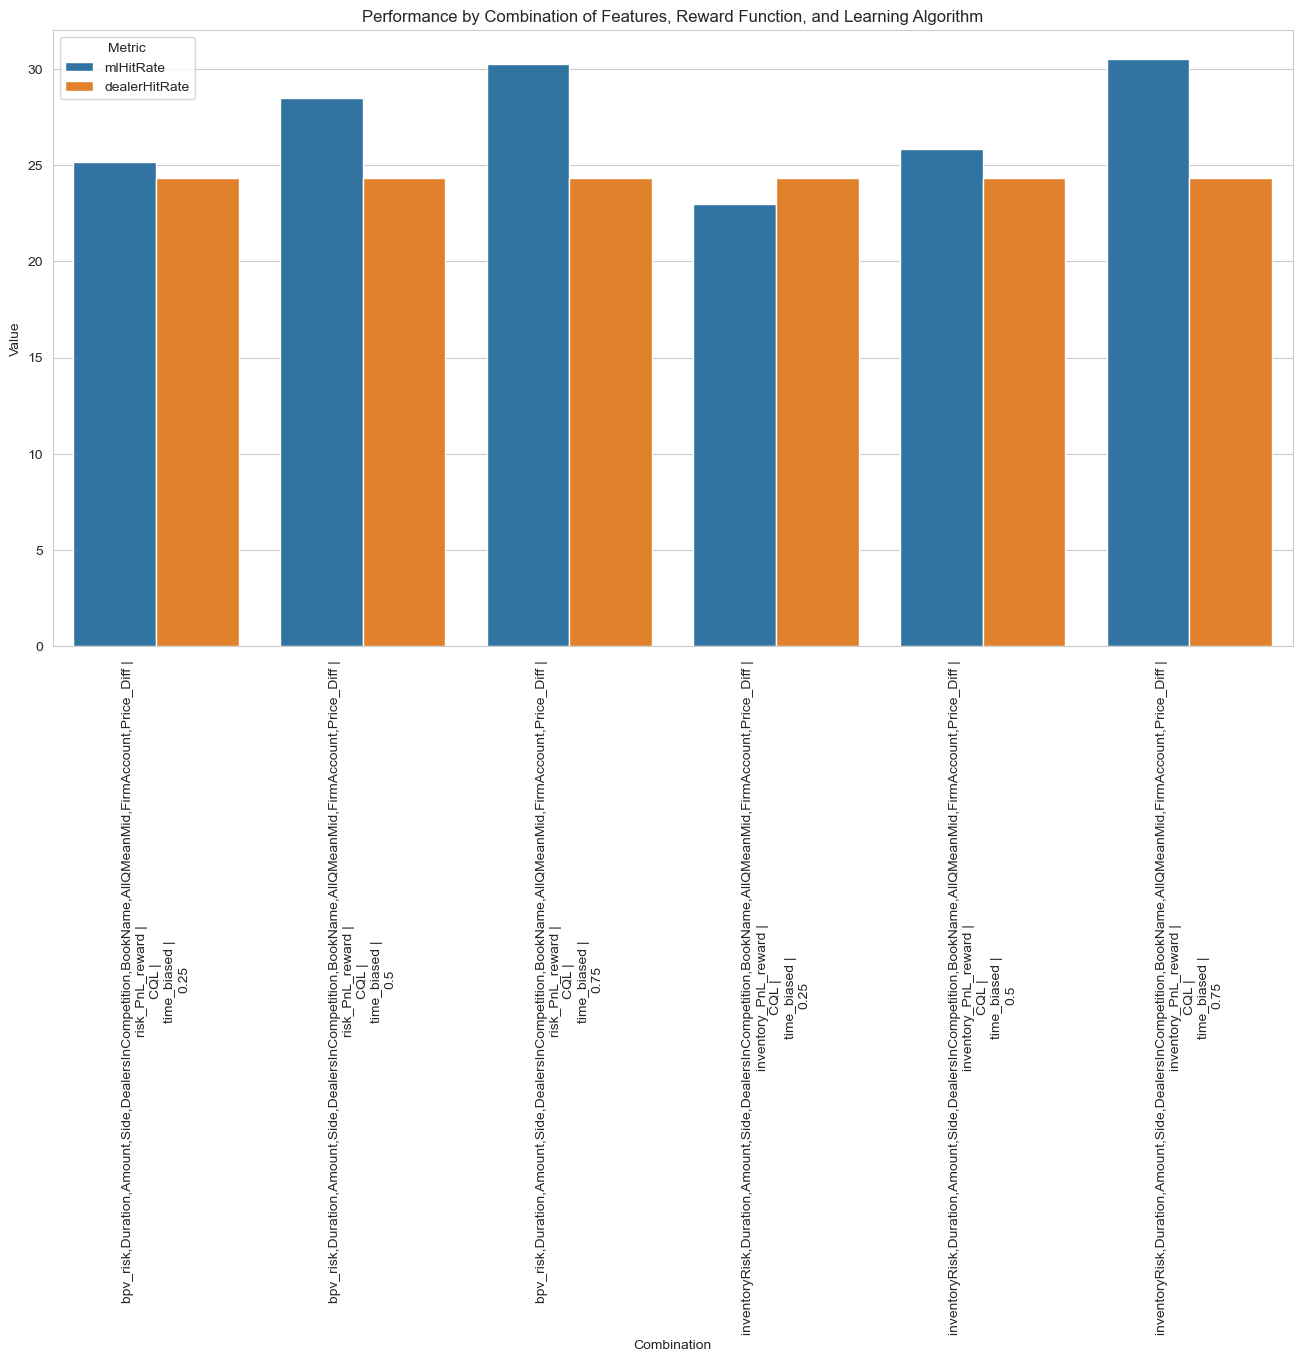

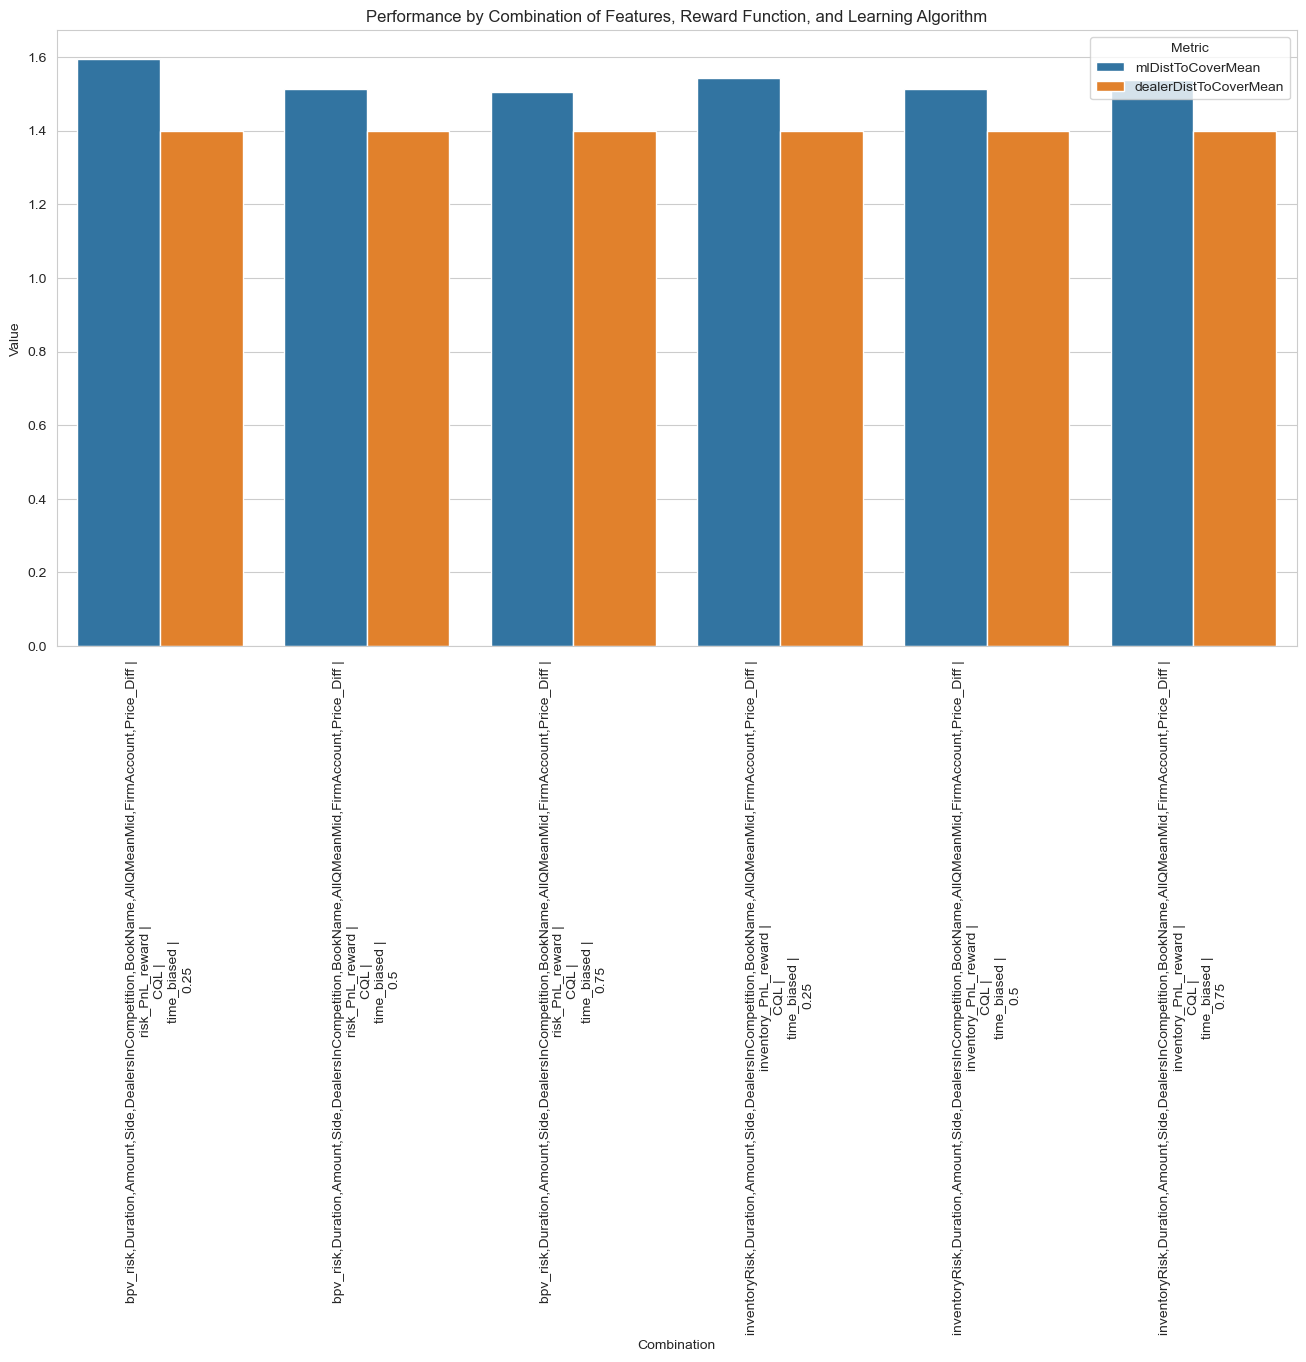

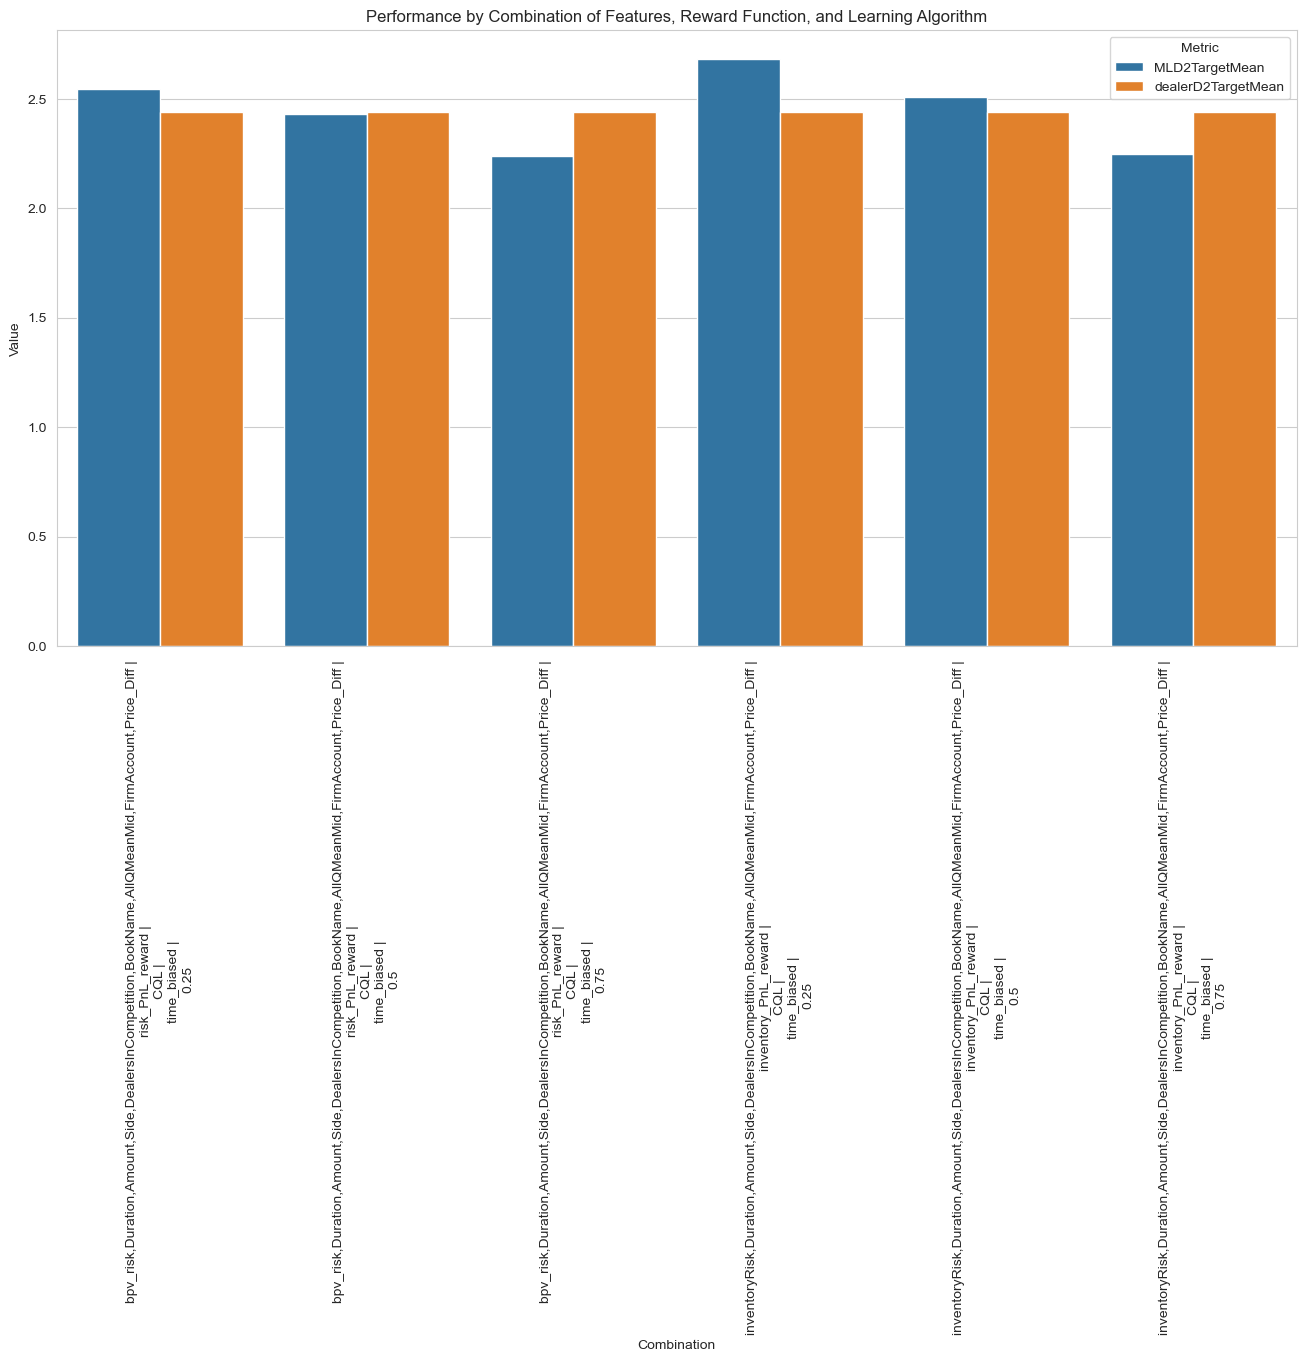

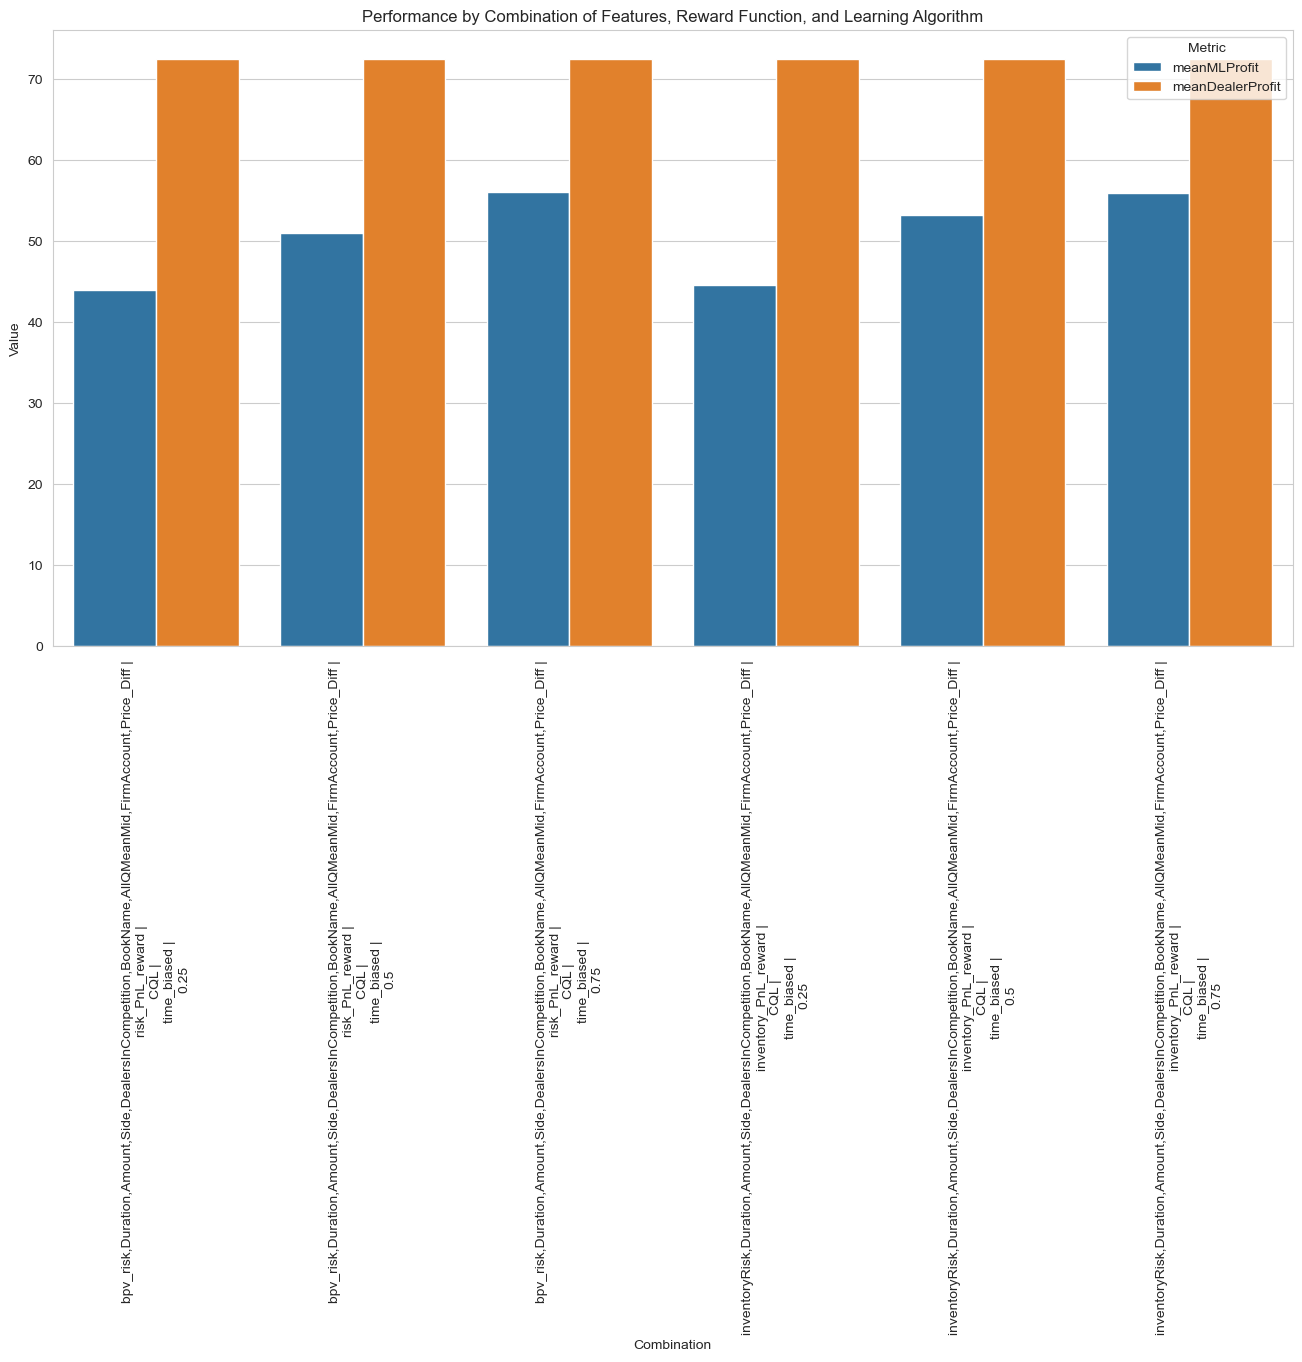

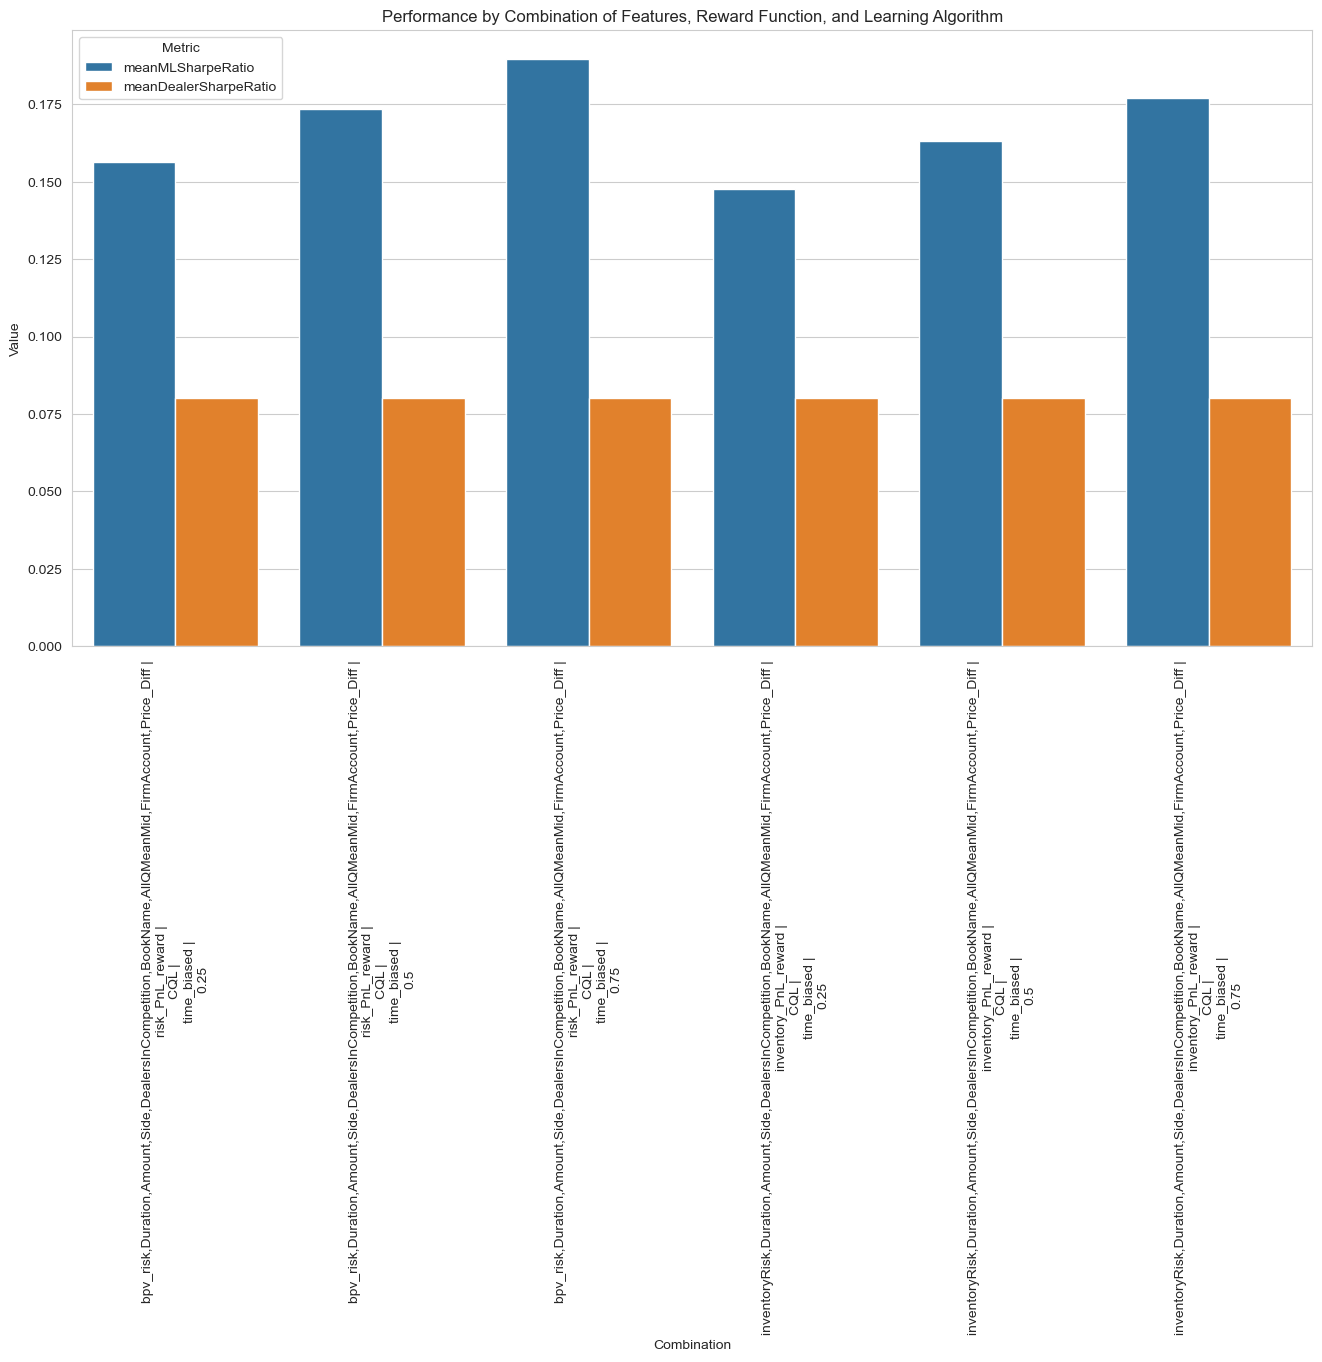

In [6]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy(), deepRL=True)

Mean Field Experiments

In [12]:
#Configs 

sample_methods = [
    #"random",
    "time_biased"
]

alphas = [#"0.25",
          #"0.5",
          "0.75"
        ]


all_features = [
    ["bpv_risk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"],
    ["inventoryRisk", "Duration", "Amount", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid", "FirmAccount", "Price_Diff"]
    
]

all_reward_functions = [
    inventory_PnL_reward,
    risk_PnL_reward,
]

learning_algorithms = [
    'CQL_Segmented'
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
           "meanMLSharpeRatio", "meanDealerSharpeRatio", "meanDealerSharpeRatioNoNeg", "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm, sample_method, alpha)
     for features, reward_function, learning_algorithm, sample_method, alpha in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms, sample_methods, alphas)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
         (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward")))],
    names=["Features", "Reward Function", "Learning Algorithm", "Sample method", "Alpha"])

Processing Key: ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'CQL_Segmented', 'time_biased', '0.75')
seed in CQL:  42


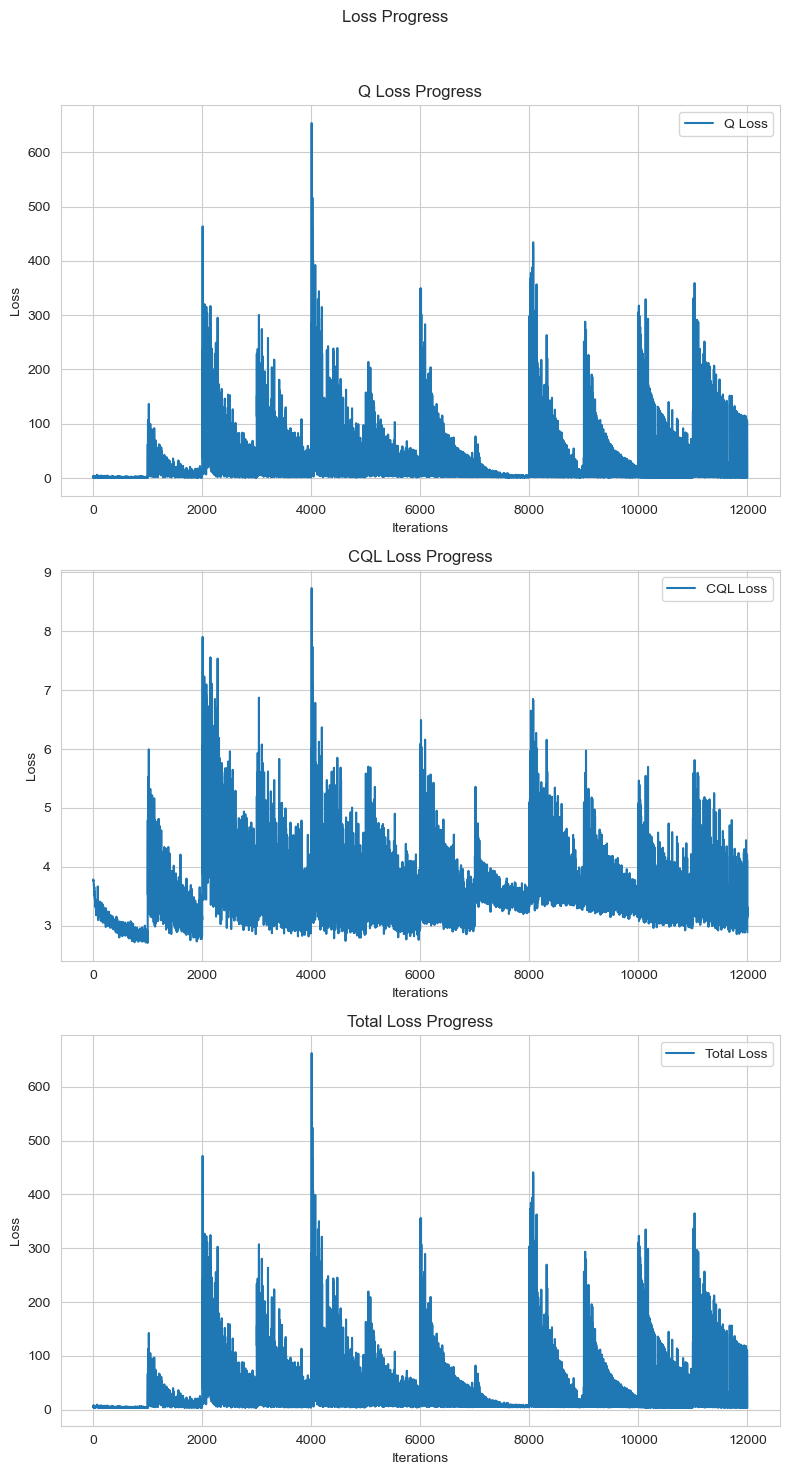

Desired HR: 22.871376811594203 

Metrics for ('bpv_risk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'risk_PnL_reward', 'CQL_Segmented', 'time_biased', '0.75'): {'dealerHitRate': 24.36, 'mlHitRate': 20.79, 'MLWinShare': 20.868249385098085, 'mlDistToCoverMean': 1.65, 'mlDistToCoverStd': 1.8380714337467896, 'dealerDistToCoverMean': 1.4, 'meanMLProfit': 49.7, 'meanDealerProfit': 72.4, 'meanRLReward': 0.9528115443564329, 'dealerD2TargetMean': 2.44, 'MLD2TargetMean': 5.06, 'MLD2TargetStd': 4.428860161633124, 'meanMLSharpeRatio': 0.06, 'meanDealerSharpeRatio': 0.08, 'meanDealerSharpeRatioNoNeg': 0.08, 'DealerNetInventoryDiff': -91551625.08999991, 'MLNetInventoryDiff': 114101694.05000007}
Processing Key: ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'inventory_PnL_reward', 'CQL_Segmented', 'time_biased', '0.75')
seed in CQL:  42


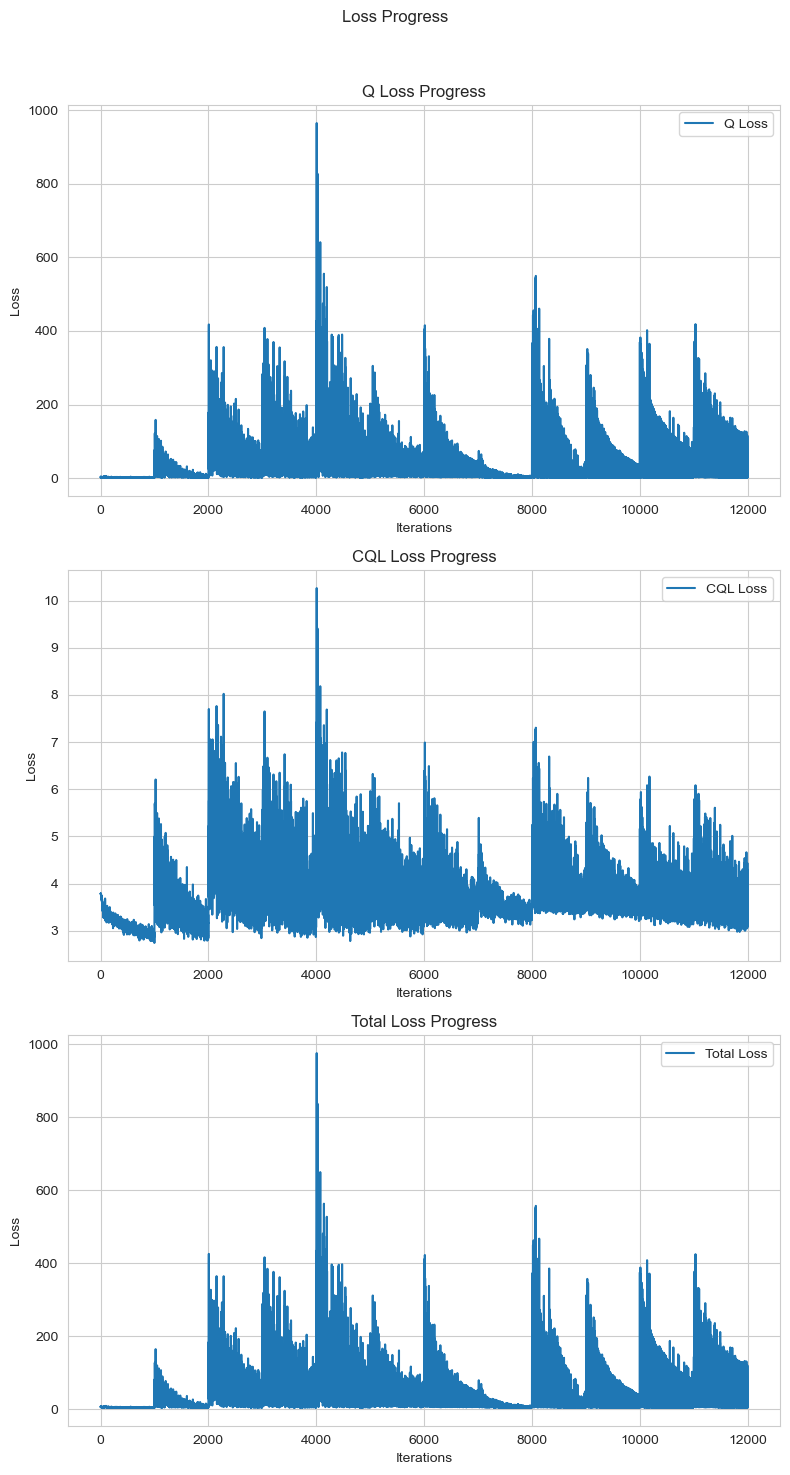

Desired HR: 22.871376811594203 

Metrics for ('inventoryRisk,Duration,Amount,Side,DealersInCompetition,BookName,AllQMeanMid,FirmAccount,Price_Diff', 'inventory_PnL_reward', 'CQL_Segmented', 'time_biased', '0.75'): {'dealerHitRate': 24.36, 'mlHitRate': 12.28, 'MLWinShare': 16.868154257109357, 'mlDistToCoverMean': 1.69, 'mlDistToCoverStd': 1.7562886858290734, 'dealerDistToCoverMean': 1.4, 'meanMLProfit': 47.9, 'meanDealerProfit': 72.4, 'meanRLReward': 0.9509767425742538, 'dealerD2TargetMean': 2.44, 'MLD2TargetMean': 5.11, 'MLD2TargetStd': 4.081745968265537, 'meanMLSharpeRatio': 0.06, 'meanDealerSharpeRatio': 0.08, 'meanDealerSharpeRatioNoNeg': 0.08, 'DealerNetInventoryDiff': -91551625.08999991, 'MLNetInventoryDiff': -141184804.20999992}
Final Results DataFrame:
                                                                                                               dealerHitRate  \
Features                                           Reward Function      Learning Algorithm Sample meth

In [ ]:
# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

for features, reward_function, learning_algorithm, sample_method, alpha in itertools.product(all_features, all_reward_functions, 
                                                                                             learning_algorithms, sample_methods, alphas):
    # Skip invalid combinations
    if not (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
            ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward") and
            (("delta_h_t" in features and reward_function.__name__ == "hitrate_target_reward") or
             ("delta_h_t" not in features and reward_function.__name__ != "hitrate_target_reward"))):
        continue 
    
    # Create MultiIndex-compatible key
    features_key = ",".join(features)  # Join features into a string
    key = (features_key, reward_function.__name__, learning_algorithm, sample_method, alpha)
    print(f"Processing Key: {key}")
    
    # Initialize components and train agent
    opponent_actions = learning_algorithm in ["CQL_MarkovGame"]
    discretize_actions = False if learning_algorithm == "BCQ" else True
    reward_terms = True if learning_algorithm == "CQL_Segmented" else False

    data_transformer = DataTransformerDeep(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
        reward_function=reward_function, opponent_actions=opponent_actions, 
        discretize_actions=discretize_actions,
        reward_terms=reward_terms)
    
    agent = DeepRFQAgent(data_transformer=data_transformer, random=True)
    agent.train(train_df.copy(), algorithm=learning_algorithm, num_train_steps=4000, batch_size=256, 
                follow_progress=True, alpha=float(alpha), sample_method=sample_method, dist_fn="rel")

    modelEvaluator = RFQModelEval(agent)
    modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, 
                                            print_violin_plot=False, plot_spreads=False, random_policy=False)
    
    # Extract metrics safely
    modelPerformanceSubset = {metric: modelPerformance.get(metric, np.nan) for metric in metrics}
    print(f"Metrics for {key}: {modelPerformanceSubset}")
    
    # Update results_df
    results_df.loc[key] = pd.Series(modelPerformanceSubset)

# Display the results DataFrame
print("Final Results DataFrame:")
print(results_df)


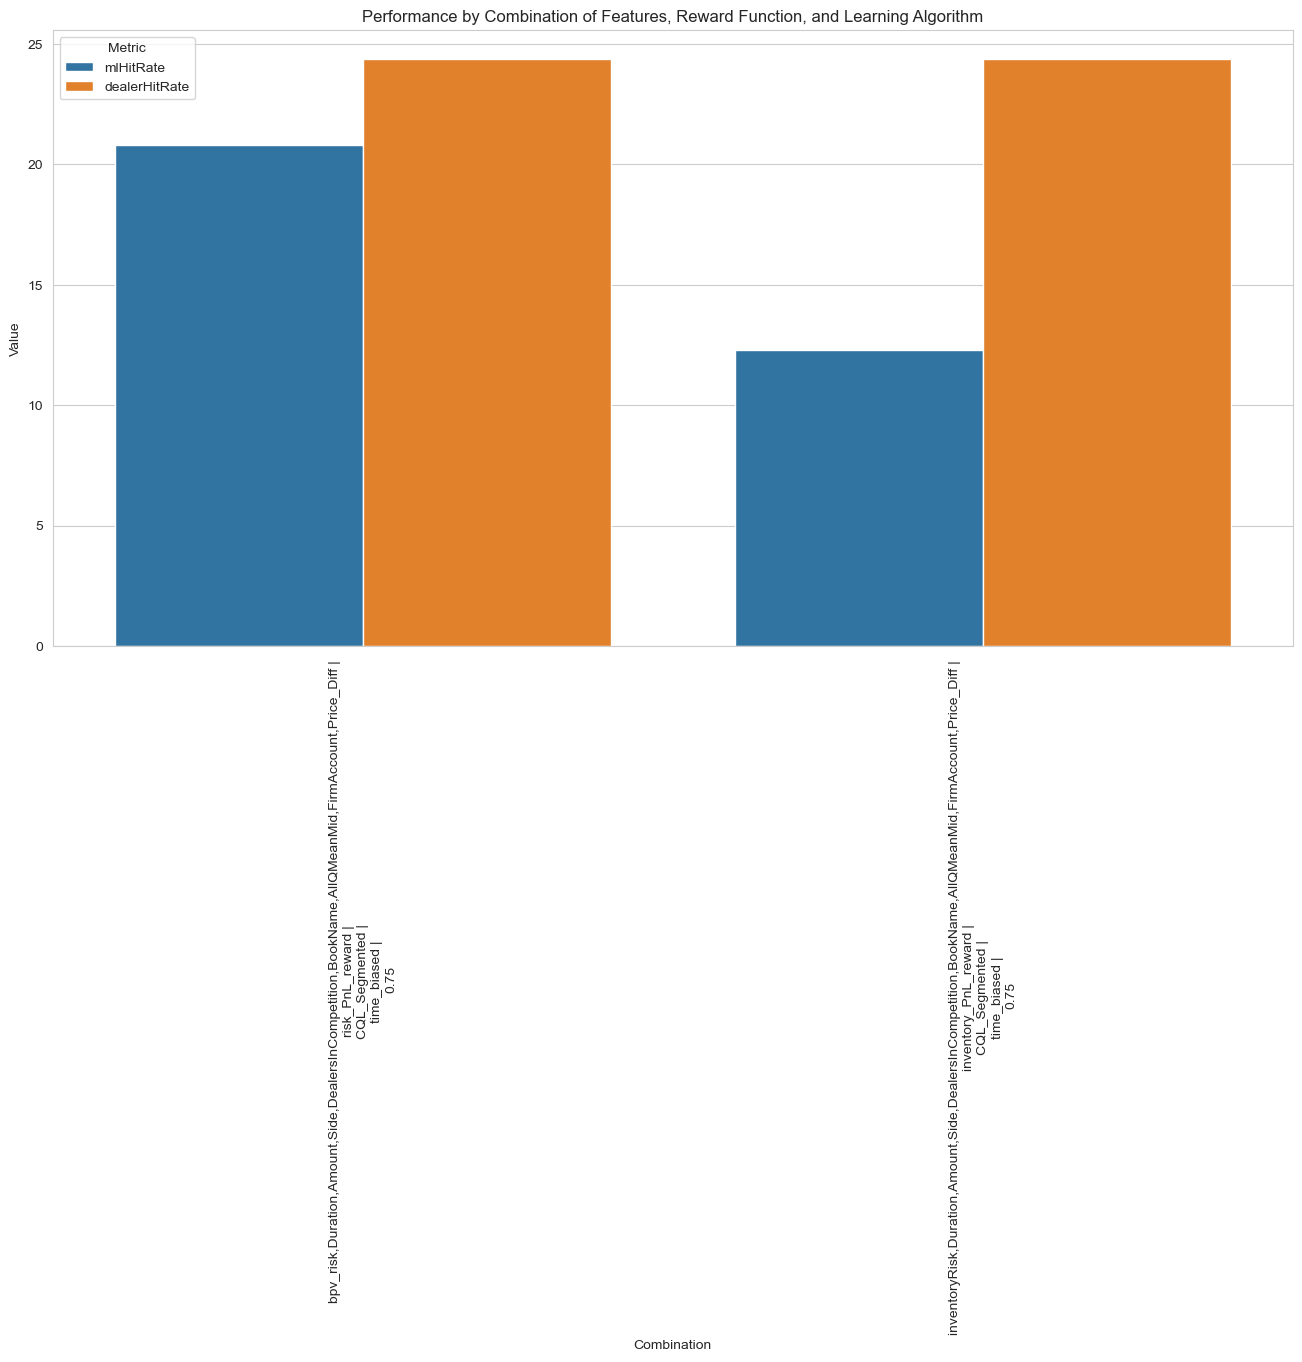

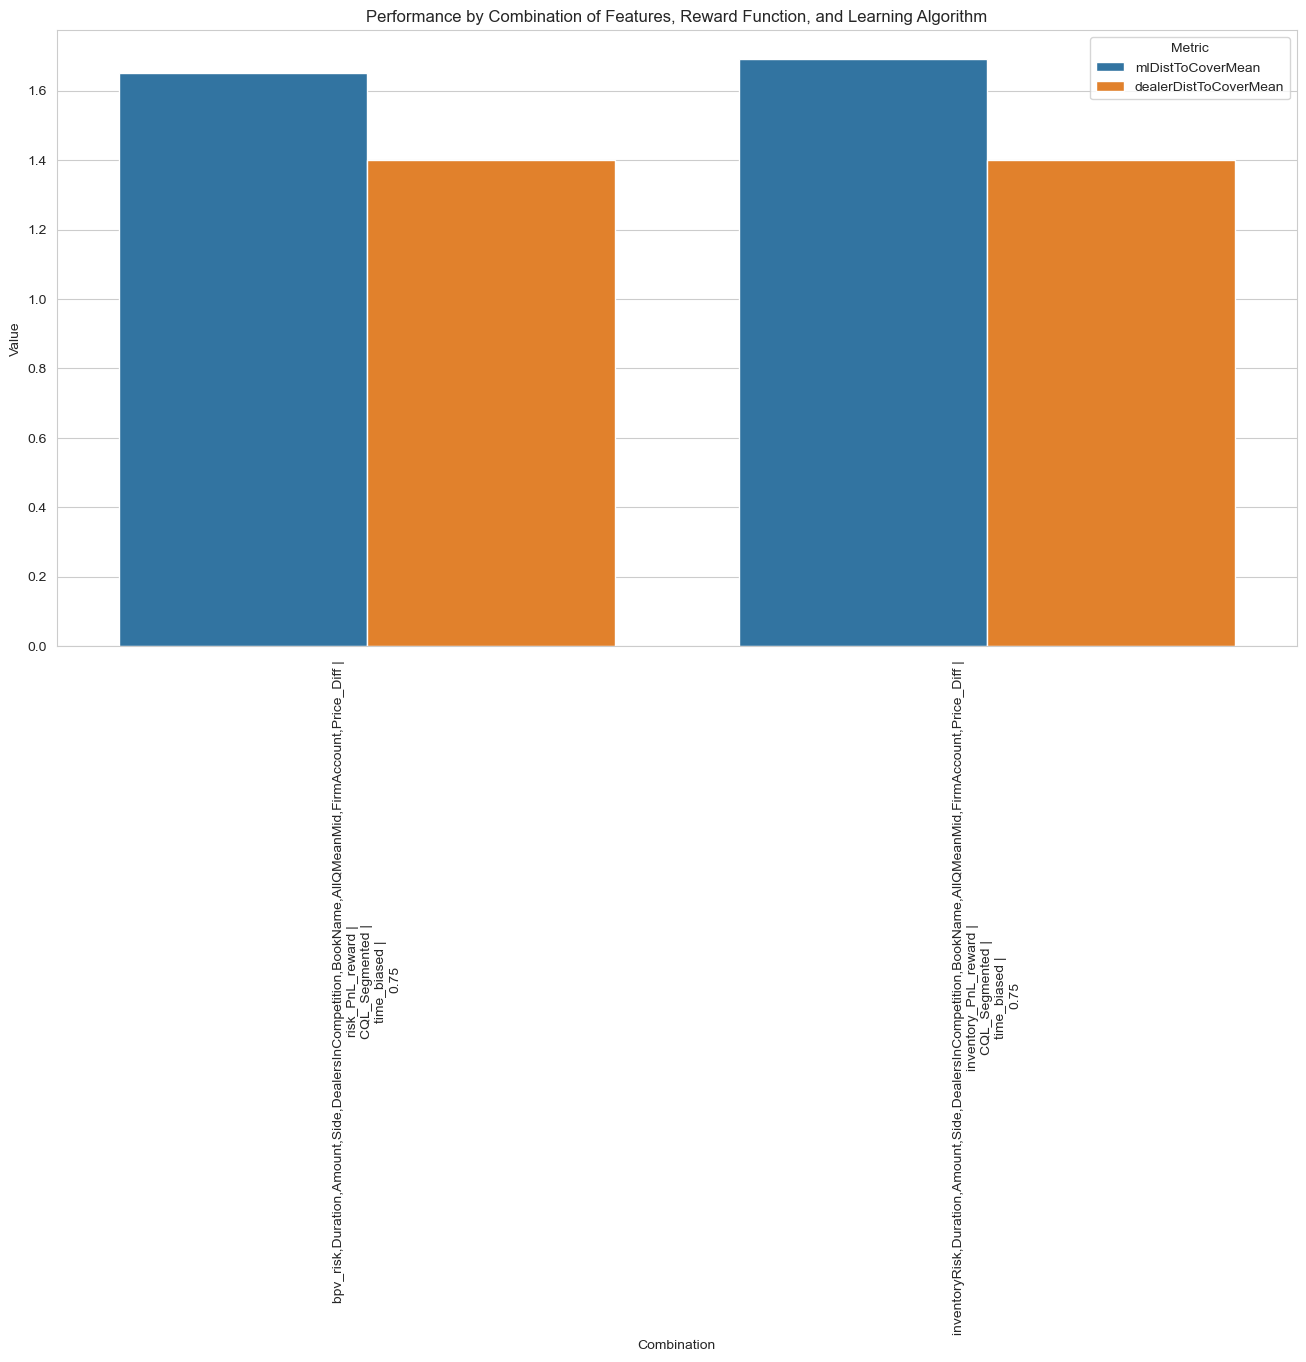

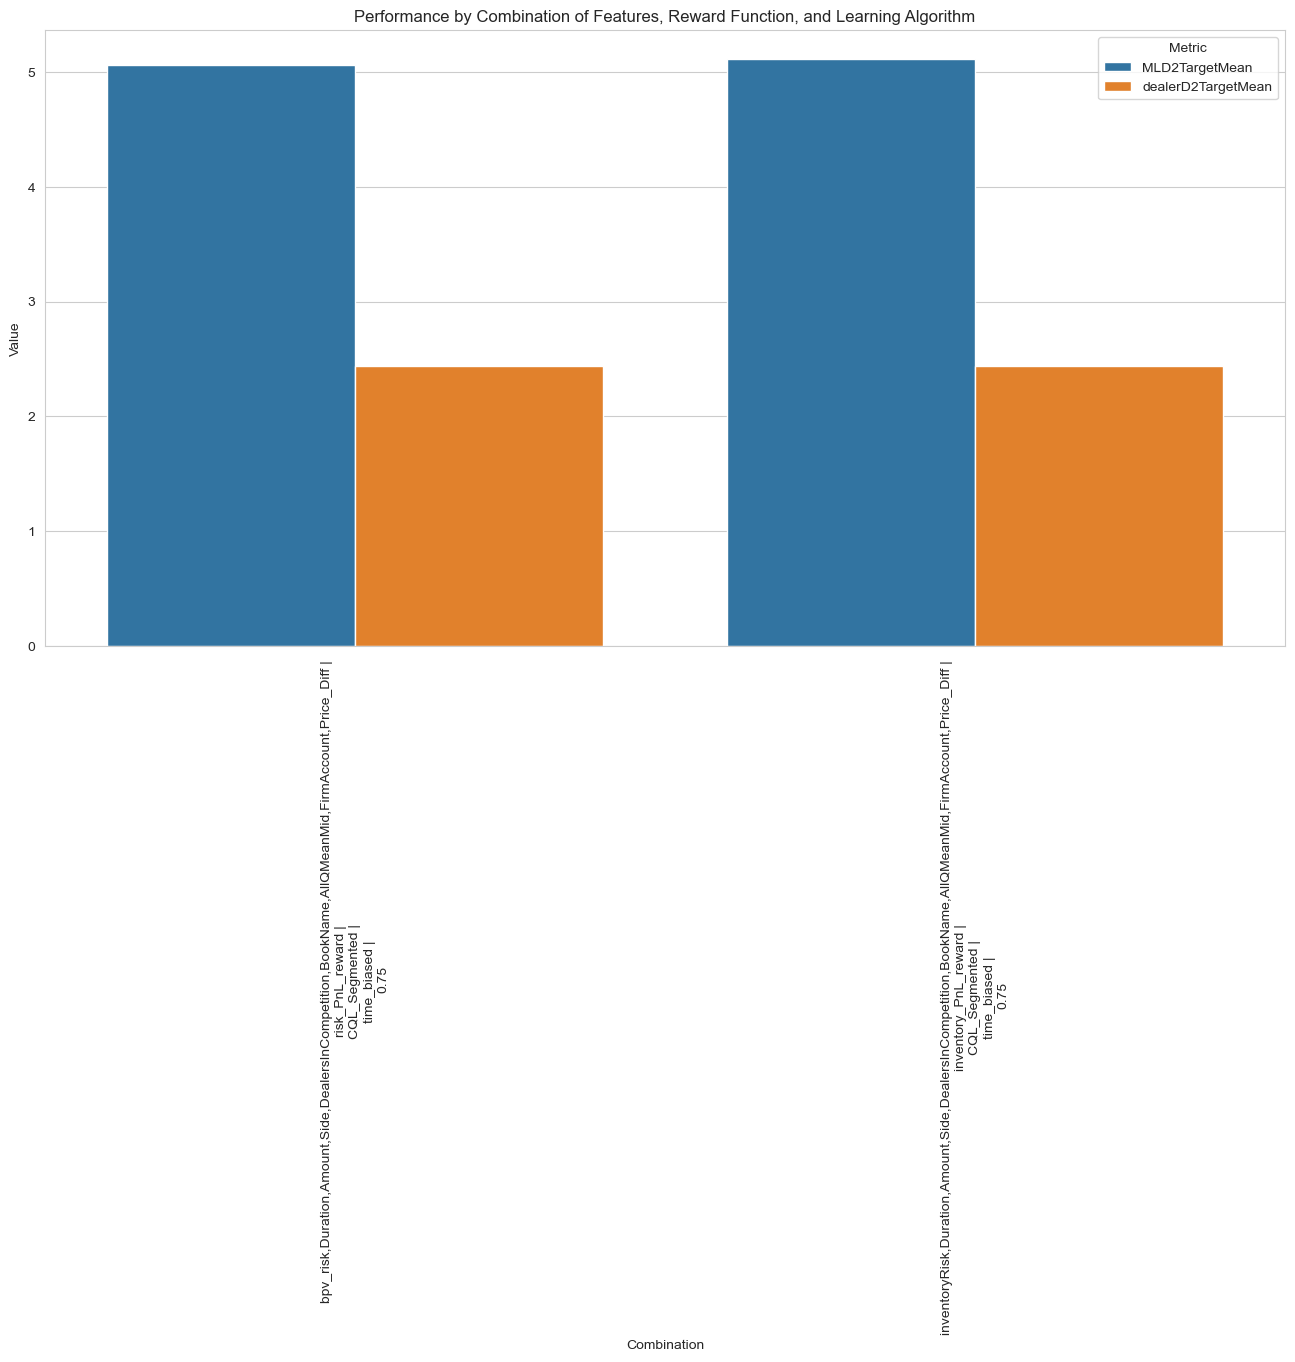

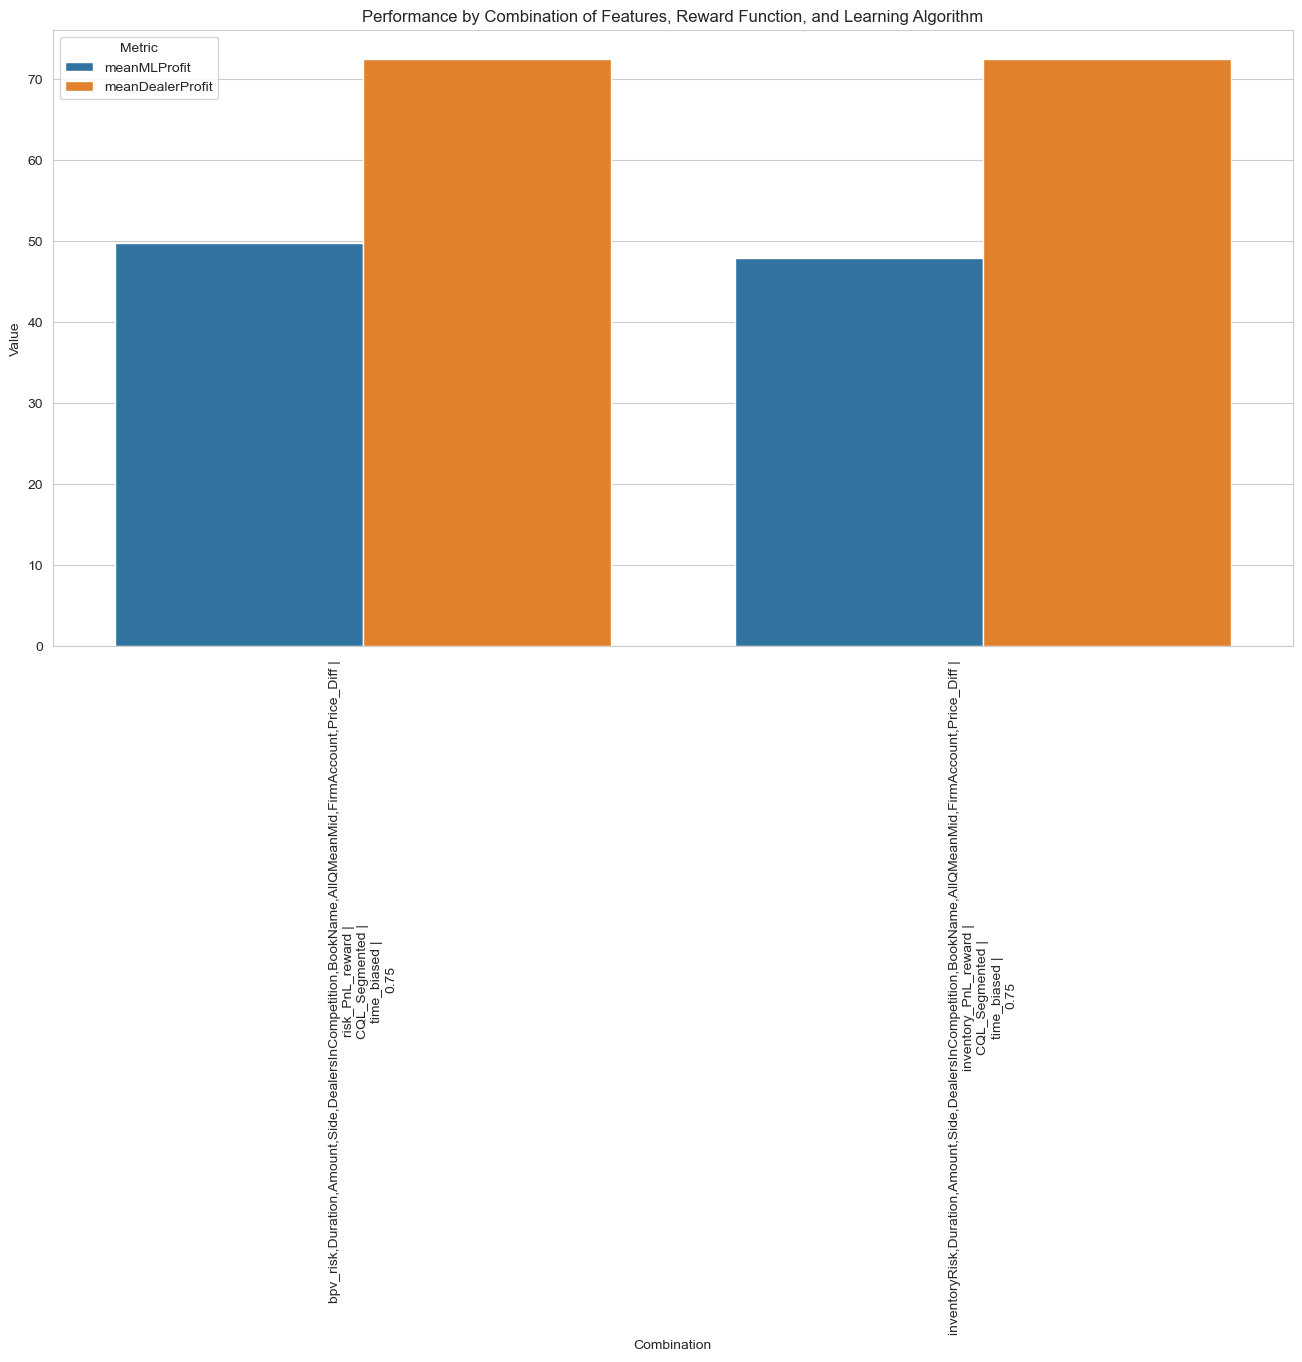

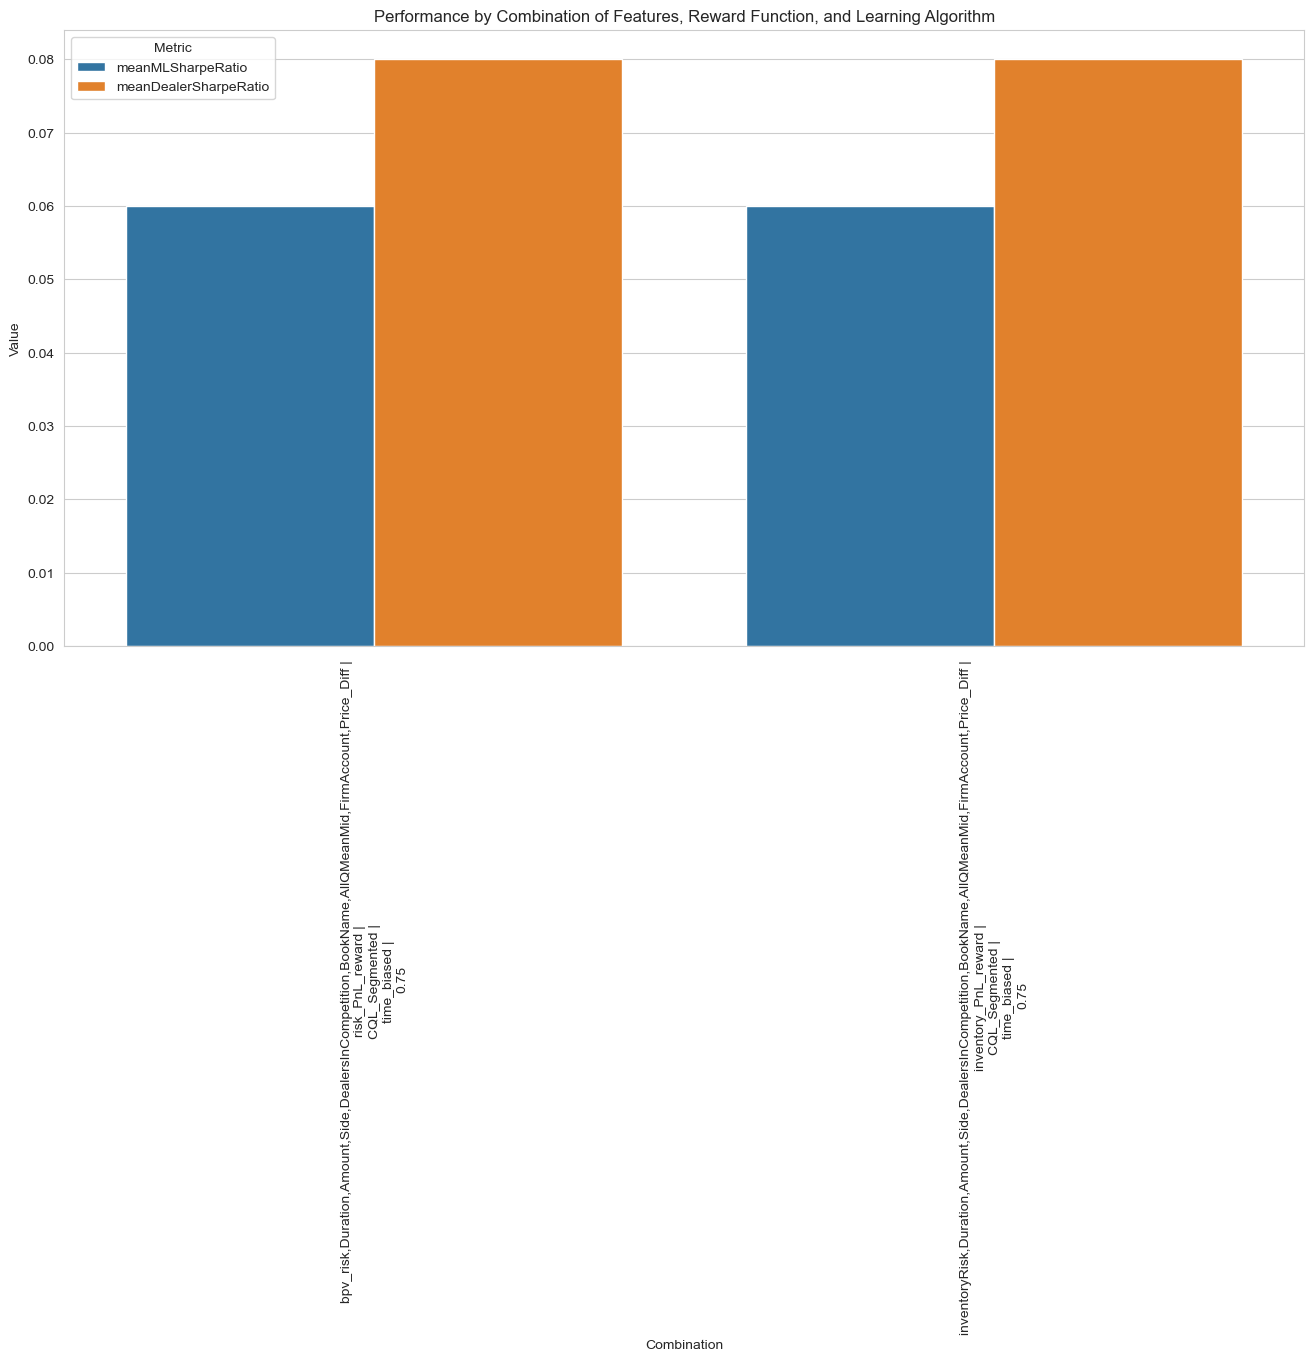

In [14]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy(), deepRL=True)